In [1]:
import numpy as np
import matplotlib.pyplot as plt
import koopman as koop
from scipy import stats
from scipy.integrate import quad 


# Rotation on a circle

The stochastic equation is: $x_{t +1} = x_t + \nu + \omega t$
where $\nu$ is a fixed rotation angle and $\omega_t\sim Uniform[-0.5, 0.5]$. The function below generates a trajectory for number of time steps T, with rotation angle $\nu$ and initial condition $x_0$.

In [2]:
def circle_rotation(x0, T, nu):
    solution  = np.zeros(T)
    solution[0] = x0
    for i in range(1, T):
        # draw random number
        omega = np.random.rand() - 0.5
        # update
        solution[i] =np.mod(solution[i - 1] + nu + omega, 2*np.pi)
    return solution

Start by plotting a trajectory

Text(0.5, 1.0, 'Circle rotations for  100 time steps')

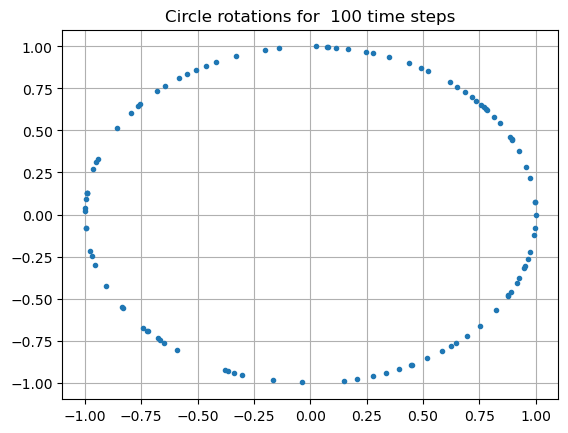

In [3]:
T = 100
rotation = circle_rotation(0, T, 0.5)
plt.plot(np.cos(rotation), np.sin(rotation), '.')
plt.grid()
plt.title('Circle rotations for  %i time steps' % T)

## L2 case
We start with Fourier basis functions made of sine and cosine up to order 5. Then the number of basis vectors is N = 10. The measures are $\sin{ix}dx, \cos{ix}dx$ for $i = 1,\dots,  5$. We sample K = 100 points from each measure and evolve them forward for T = 10 time steps. The data matrix is composed of the location of these $K*N$ points at time T.

First, we implemet a rejection sampling method for obtaining samples from $g_i$. We use the uniform distribution as the proposal.

In [4]:
def rejection_sample(pdf):
    while True:
        u = np.random.uniform()
        y = np.random.uniform()
        if u < pdf(y):
            return y
        

Set the hyperparameters

In [5]:
K = 100
N = 10
T = 10
nu = 0.5

Generate the data matrix by:
- sampling K points out of each of the N distributions
- propagate the points through the dynamics for time T
- record their location in the data matrix

In [6]:
data = np.zeros((K, N))
for i in range(N):
    f = lambda x:(i%2)*np.sin((i + 1)/2*x) - (i%2 - 1)*np.cos((i + 2)/2*x)
    for k in range(K):
        x0 = rejection_sample(f)
        xT = circle_rotation(x0, T, nu)
        data[k, i] = xT[-1]

Initiate the koopman object with N = 10 basis functions of type 'fourier'. 

In [10]:
K_circle = koop.koopman(10, 'fourier')
K_circle.L2_dmd(data)

In [12]:
evals, evects = np.linalg.eig(K_circle.mat)